### Стратегия:
**Модифицированная Mean-Reversion с усилением по силе тренда и волатильности**

### Гипотеза:
Сильный тренд указывает на фазу перекупленности или перепроданности, и это повышает вероятность отката.

### Идея:
- Сигналом является отклонение от локального тренда. По логарифмической цене вычисляется стандартное отклонение и скользящее среднее на окне, с их помощью считается отрицательный z-score:
$$
z = -\frac{\log P - \text{MA}}{\text{STD}}
$$
Покупка, если цена значительно отклонилась вниз от своего долгосрочного скользящего среднего значения, продажа при отклонении вверх. 
- Сигнал усиливается при более выраженном тренде (абсолютный наклон лог-цены). 
- Позиция делится на текущую волатильность, чтобы в периоды сильных колебаний она уменьшалась. Установлен минимальный порог. Это делает стратегию более устойчивой.
- Рзамеры позиции ограничены по абсолютной величине, чтобы предотвратить аномальные значения при большой/низкой волатильности

### Позиция стратегии:

$$
\text{Position}_t = 
\frac{
  -z_t \cdot w_t
}{
  \tilde{\sigma}_t
}
$$

$position \in [-L, L]$, L- максимальный размер позиции

Трендовый вес:  
$w_t = 1 + \text{scale} \cdot |\text{slope}_t|$

Нормализованная волатильность:  
$\tilde{\sigma}_t = \max(\sigma_t^{\text{vol}}, \epsilon)$

### Основание:
- Стратегия Mean-Reversion основана на предположении, что цена имеет тенденцию возвращаться к своему среднему уровню после временных экстремумов.
- Усиление веса позиции на основе тренда опирается на идею, что сильные односторонние движения часто завершаются резким откатом. Тренд используется как метрика потенциальной перекупленности/перепроданности.
- Использование волатильности в расчёте позиции стабилизирует риск и делает поведение стратегии адаптивным к рыночным условиям.

### Жизненный цикл:
В среднем рынок проводит в боковом движении (флэте) около 40–60% времени в году. Именно в таких условиях стратегия наиболее эффективна, так как извлекает прибыль из регулярных откатов после фаз перекупленности или перепроданности. 

Важно отметить, что для поддержания стабильной результативности стратегия требует регулярной переоценки параметров.

Более того, необходимо следить за макро-тенденциями на рынках: при значительных просадках цена может долго не откатывать, и в таких рыночных условиях лучше отказаться от использования этой стратегии. В фазах затяжного тренда она будет генерировать убытки.

### Развитие идеи:
- Адаптация стратегии к трендовому рынку: сделать гибридную стратегию, скомбинировав ее с trend-following. 
- При большом абсолютном значении тренда добавить лаг к открытию позиции: открывать только тогда, когда значение наклона тренда начнет уменьшаться. Аналог trailing-stop, только для открытия позиций. Значительно снизит количество ложных сигналов.
- Добавить учёт ликвидности и объемов в момент открытия позиций. Избегать сделок в периоды низкой активности.
- MA и STD рассчитываются на скользящем окне, поэтому эти индикаторы реагируют с задержкой. Можно использовать адаптивные скользящие средние для решения этой проблемы.
- Волатильность может быть недооценена перед большими движениями, илипереоценена после шоков. Необходимо ввести прогнозируемую волатильность, например из данных по опционам, или настраивать этот параметр вручную. 
- Учесть транзакционные издержки, контанго/бэквордацию при ролловере.
- Добавить стоп-лоссы

### Реализация
Для начала разработаем стратегию для одного актива, потом соберем портфель

### EDA
Импорт библиотек

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from tqdm.notebook import tqdm

Чтение данных

In [154]:
data = pd.read_csv('futures-pnls.csv')
data['timestamp'] = pd.to_datetime(data['Date'])
data = data.set_index('timestamp')

In [155]:
FUTURES = {
    "CLA": "Light Sweet Crude Oil (CLA)",
    "BTC": "CME Bitcoin (BTC)",
    "QPA": "Gasoil (Combined) (QPA)",
    "EB": "Euro/British Pound (EB)",
    "SAA": "S. African Rand (All Sessions) (SAA)",
    "PV": "Milling Wheat (PV)",
    "ZIN": "S\&P CNX Nifty Index – SGX (ZIN)",
    "ZG": "MSCI Singapore Stock Index (ZG)",
    "BPA": "British Pound (All Sessions) (BPA)",
    "MXA": "Mexican Peso (All Sessions) (MXA)",
    "CNA": "Corn (Combined) (CNA)",
    "SFA": "Swiss Franc (All Sessions) (SFA)",
    "WHA": "Wheat (Combined) (WHA)",
    "PLA": "Platinum (Nymex) Combined (PLA)",
    "KCA": "Coffee (Combined) (KCA)",
    "EUA": "Euro FX (All Sessions) (EUA)",
    "DAA": "Australian Dollar (All Sessions) (DAA)",
    "CAA": "Canadian Dollar (All Sessions) (CAA)",
    "LHA": "Lean Hogs (All Sessions) (LHA)",
    "CTA": "Cotton (Combined) (CTA)",
    "SBA": "Sugar #11 (Combined) (SBA)",
    "CCA": "Cocoa (Combined) (CCA)",
    "NKD": "Nikkei 225 (Globex) (NKD)",
    "USAA": "30 Year Bond (Combined) (USAA)",
    "GCA": "Gold (Combined) (GCA)",
    "NGA": "Natural Gas (Combined) (NGA)",
    "VX": "CBOE Volatility Index VIX (VX)",
    "PAA": "Palladium (Combined) (PAA)",
    "BOA": "Bean Oil (Combined) (BOA)",
    "EP": "E Mini S&P (EP)",
    "CPA": "Copper(Combined) (CPA)",
    "GLA": "Live Cattle (All Sessions) (GLA)",
}

CATEGORIES = {
    "QPA": ("Commodities", "Energy"),
    "CLA": ("Commodities", "Energy"),
    "CNA": ("Commodities", "Grains"),
    "WHA": ("Commodities", "Grains"),
    "PLA": ("Commodities", "Precious Metals"),
    "KCA": ("Commodities", "Softs"),
    "GCA": ("Commodities", "Precious Metals"),
    "NGA": ("Commodities", "Energy"),
    "LHA": ("Commodities", "Livestock"),
    "CTA": ("Commodities", "Softs"),
    "SBA": ("Commodities", "Softs"),
    "CCA": ("Commodities", "Softs"),
    "PAA": ("Commodities", "Precious Metals"),
    "BOA": ("Commodities", "Oilseeds"),
    "PV": ("Commodities", "Grains"),
    "CPA": ("Commodities", "Industrial Metals"),
    "GLA": ("Commodities", "Livestock"),
    "EB": ("Currencies", "Crosses"),
    "SFA": ("Currencies", "Major"),
    "BPA": ("Currencies", "Major"),
    "MXA": ("Currencies", "Emerging"),
    "SAA": ("Currencies", "Emerging"),
    "EUA": ("Currencies", "Major"),
    "DAA": ("Currencies", "Major"),
    "CAA": ("Currencies", "Major"),
    "BTC": ("Cryptoсurrencies", "Major"),
    "ZIN": ("Equity Indices", "Emerging"),
    "NKD": ("Equity Indices", "Asia"),
    "EP": ("Equity Indices", "US"),
    "ZG": ("Equity Indices", "Asia"),
    "USAA": ("Rates/Bonds", "Long-Term Bonds"),
    "VX": ("Volatility", "Index Volatility"),
}



<>:8: SyntaxWarning: invalid escape sequence '\&'
<>:8: SyntaxWarning: invalid escape sequence '\&'
C:\Users\masha\AppData\Local\Temp\ipykernel_25812\3157261690.py:8: SyntaxWarning: invalid escape sequence '\&'
  "ZIN": "S\&P CNX Nifty Index – SGX (ZIN)",


In [156]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4760384 entries, 2011-12-01 00:00:00 to 2025-03-31 22:59:00
Data columns (total 27 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Date    object 
 1   BOA     float64
 2   BPA     float64
 3   BTC     float64
 4   CAA     float64
 5   CCA     float64
 6   CLA     float64
 7   CNA     float64
 8   CPA     float64
 9   CTA     float64
 10  DAA     float64
 11  EP      float64
 12  EUA     float64
 13  GCA     float64
 14  GLA     float64
 15  KCA     float64
 16  LHA     float64
 17  MXA     float64
 18  NGA     float64
 19  NKD     float64
 20  PAA     float64
 21  PLA     float64
 22  SBA     float64
 23  SFA     float64
 24  USAA    float64
 25  VX      float64
 26  WHA     float64
dtypes: float64(26), object(1)
memory usage: 1016.9+ MB


В целях оптимизации памяти и удобства:

In [157]:
float_cols = data.select_dtypes(include=['float64']).columns
data[float_cols] = data[float_cols].astype('float32')

In [158]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 100)

Проверка временного периода данных

In [159]:
print(f'Период данных: от {data.index.min()} до {data.index.max()}')

Период данных: от 2011-12-01 00:00:00 до 2025-03-31 22:59:00


Дублирующиеся строки по индексу или дате:

In [160]:
data.index.duplicated().sum()

np.int64(0)

отсутствуют.

Визуализируем пропуски 

C:\Users\masha\AppData\Local\Temp\ipykernel_25812\2300879423.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='T')
C:\Users\masha\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


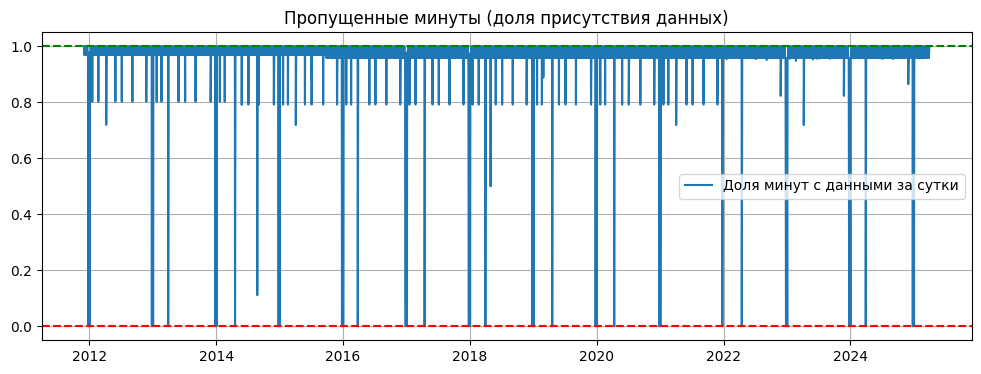

In [161]:
full_index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='T')
full_index = full_index[full_index.dayofweek < 5]

data_presence = pd.Series(0, index=full_index)
data_presence[data.index] = 1

rolling_presence = data_presence.rolling('1D').mean()

plt.figure(figsize=(12, 4))
plt.plot(rolling_presence, label='Доля минут с данными за сутки')
plt.axhline(1, color='green', linestyle='--')
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.title('Пропущенные минуты (доля присутствия данных)')
plt.grid(True)
plt.show()


Сделаем более близкий разрез чтобы визуально увидеть закономерности

C:\Users\masha\AppData\Local\Temp\ipykernel_25812\3455893853.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(start=start_date, end=end_date, freq='T')


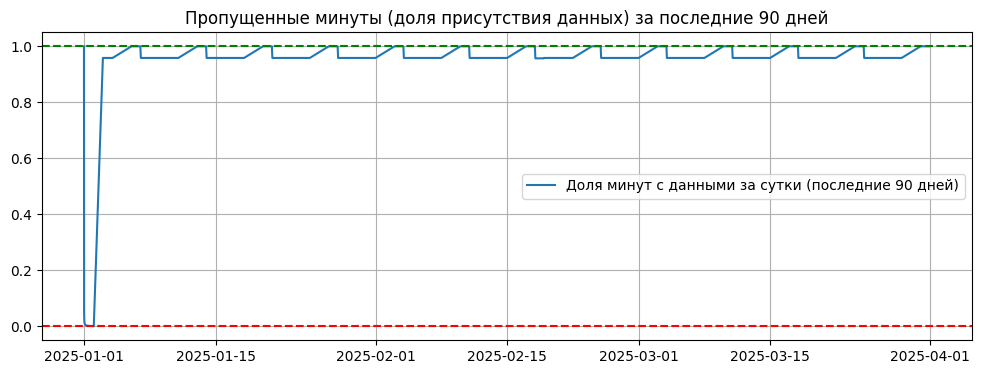

In [162]:
end_date = data.index.max()
start_date = end_date - pd.Timedelta(days=90)

full_index = pd.date_range(start=start_date, end=end_date, freq='T')
full_index = full_index[full_index.dayofweek < 5]

data_presence = pd.Series(0, index=full_index)
recent_data_index = data.index[(data.index >= start_date) & (data.index <= end_date)]
data_presence.loc[recent_data_index] = 1

rolling_presence = data_presence.rolling('1D').mean()

plt.figure(figsize=(12, 4))
plt.plot(rolling_presence)
plt.axhline(1, color='green', linestyle='--')
plt.axhline(0, color='red', linestyle='--')
plt.legend(['Доля минут с данными за сутки (последние 90 дней)'])
plt.title('Пропущенные минуты (доля присутствия данных) за последние 90 дней')
plt.grid(True)
plt.show()

Систематические пропуски- из за графика работы бирж и времени торгов фьючерсов. Выбросы- выходные и праздничные дни.

Посмотрим на долю пропусков в процентах

In [163]:
data.isna().mean() * 100

Date     0.000000
BOA     38.949589
BPA      9.385104
BTC     66.159096
CAA     11.369713
CCA     67.055326
CLA      1.719147
CNA     39.690264
CPA      7.055481
CTA     54.780434
DAA      5.058205
EP       1.944276
EUA      3.341894
GCA      1.274330
GLA     76.347202
KCA     64.025696
LHA     76.355206
MXA     35.869858
NGA     15.430037
NKD     34.352523
PAA     63.458662
PLA     26.771265
SBA     61.434708
SFA     22.017510
USAA    14.880417
VX      38.196582
WHA     43.174857
dtype: float64

Есть очень много пропусков. Активы с самыми большими пропусками низколиквидны, так что можно предположить, что при сборе данных значение "NaN" появлялось тогда, когда в эту минуту небыло сделок и/или изменений цены. 

Проверим дни недели и часы:

In [164]:
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek

In [165]:
data['dayofweek'].unique()

array([3, 4, 0, 1, 2], dtype=int32)

Есть данные за 5 рабочих дней недели. Ошибок в данных нет

In [166]:
data['hour'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int32)

Есть данные за все 24 часа- некоторые фьючерсы торгуются круглосуточно

Заполним пропуски с помощью метода линейной интерполяции, и ресемплируем данные в минутные

In [167]:
data = data.select_dtypes(include=[np.number])
data = data.interpolate(method='linear')
daily_prices = data.resample('1D').last()

Визуализация изменений цен активов по категориям

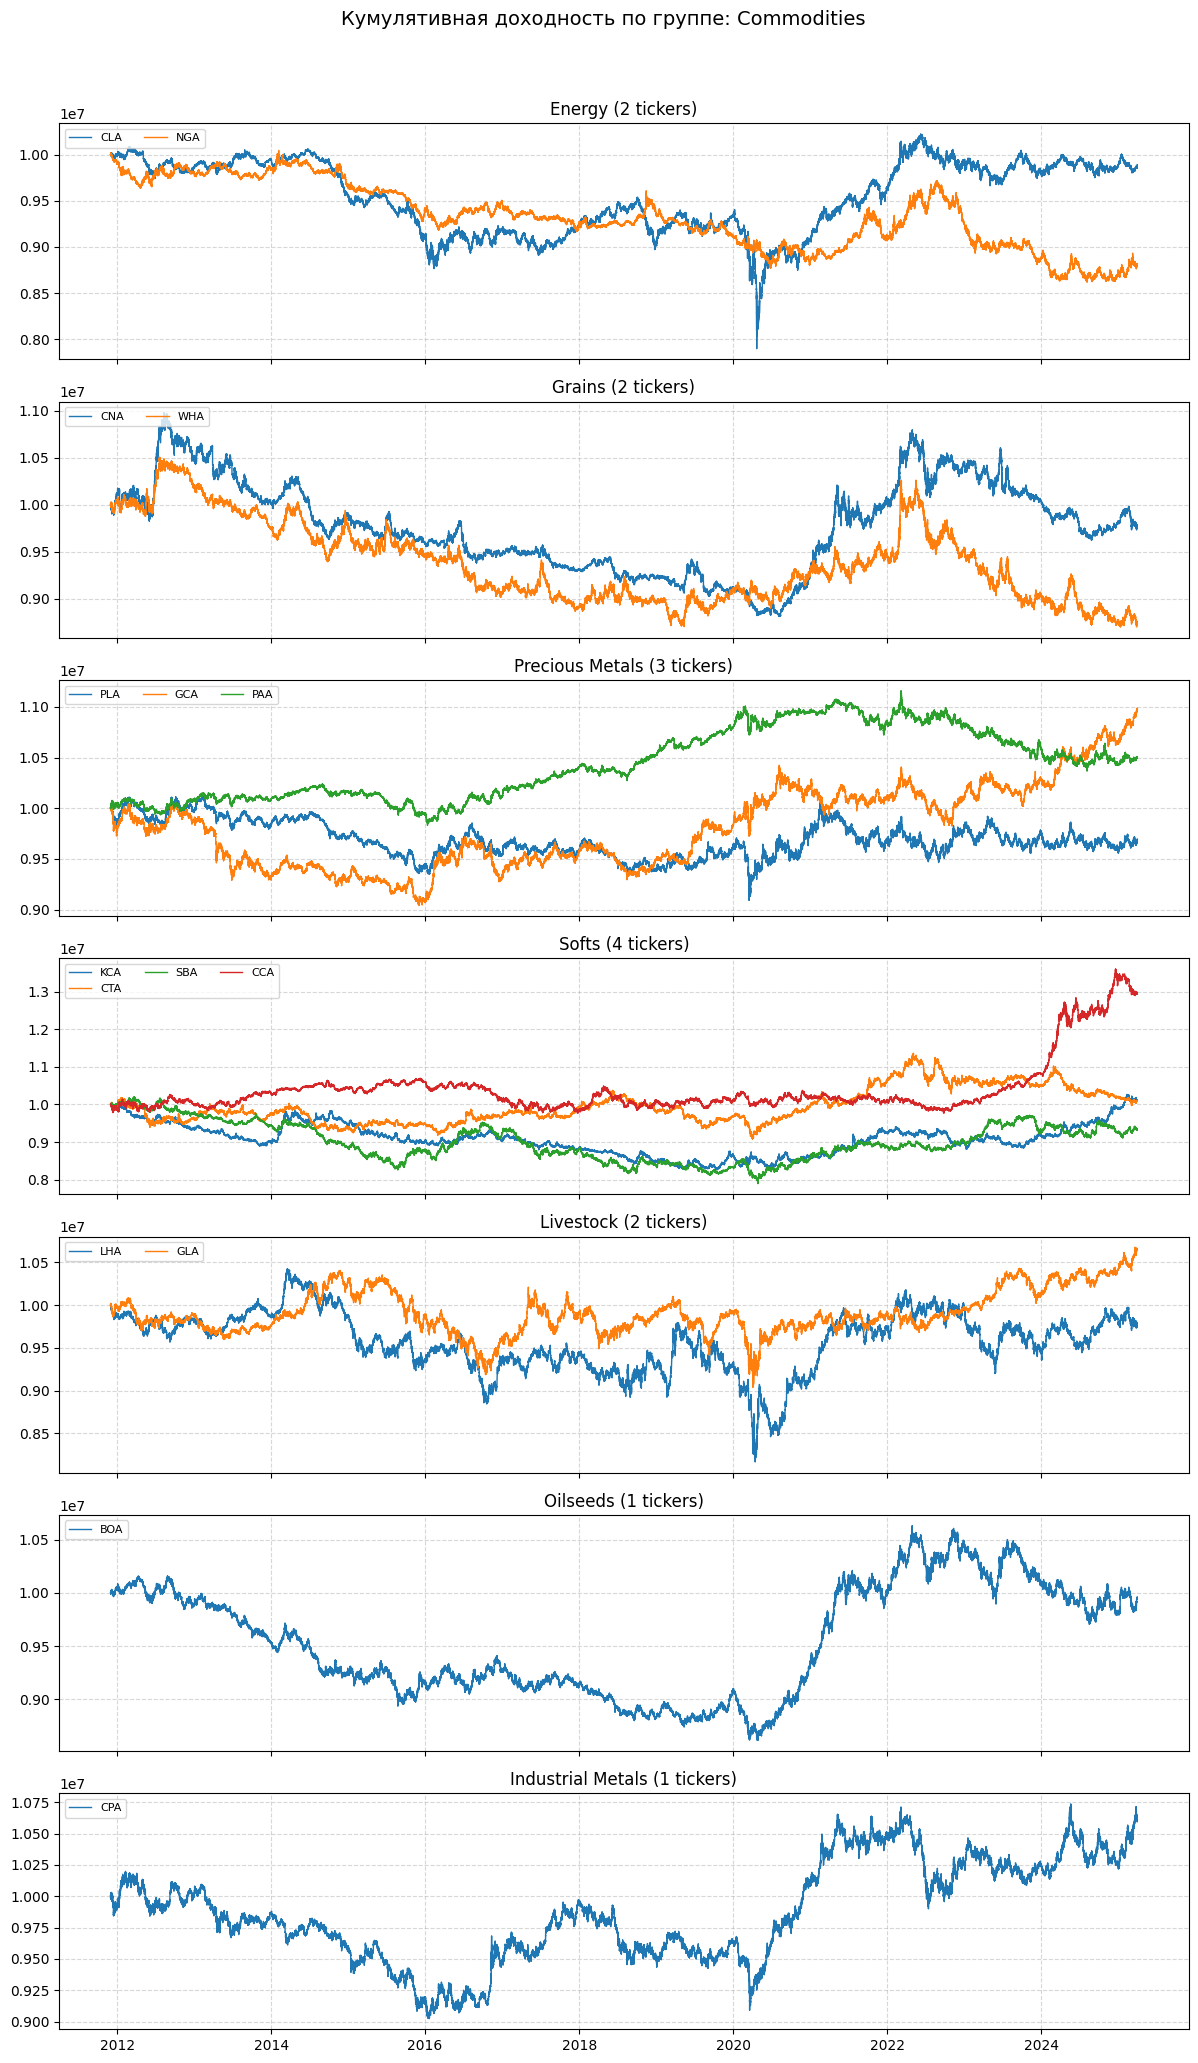

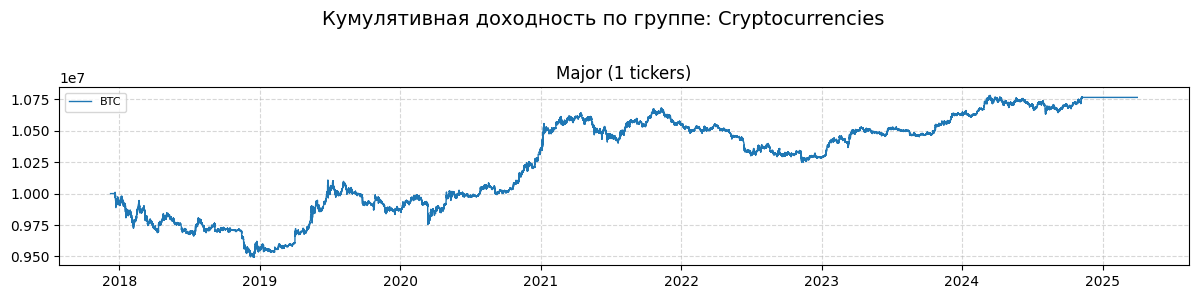

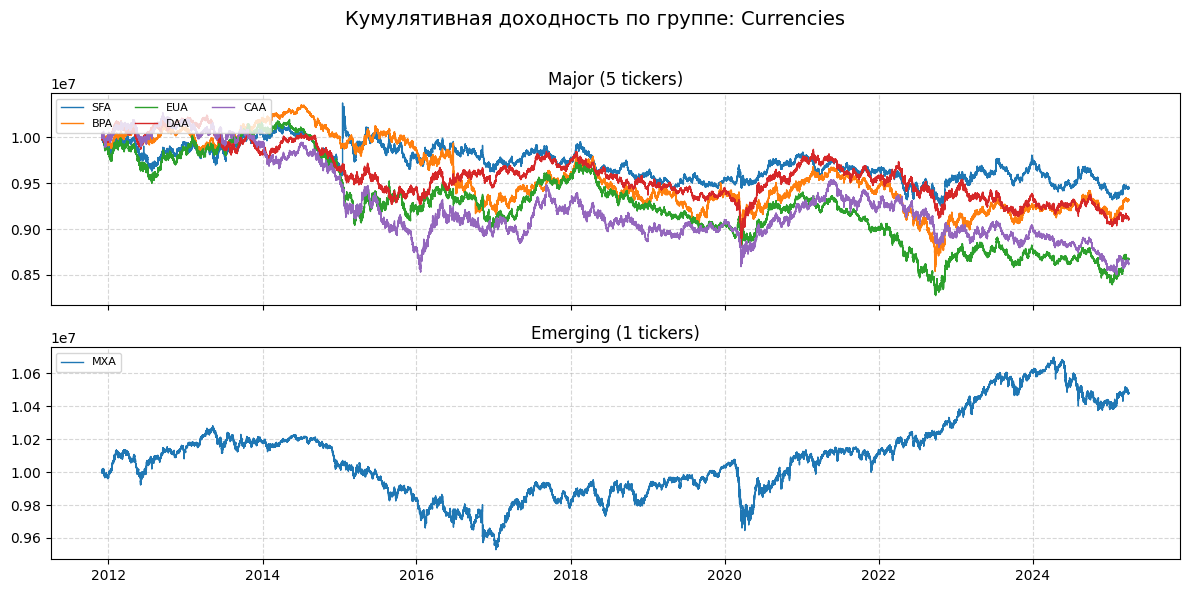

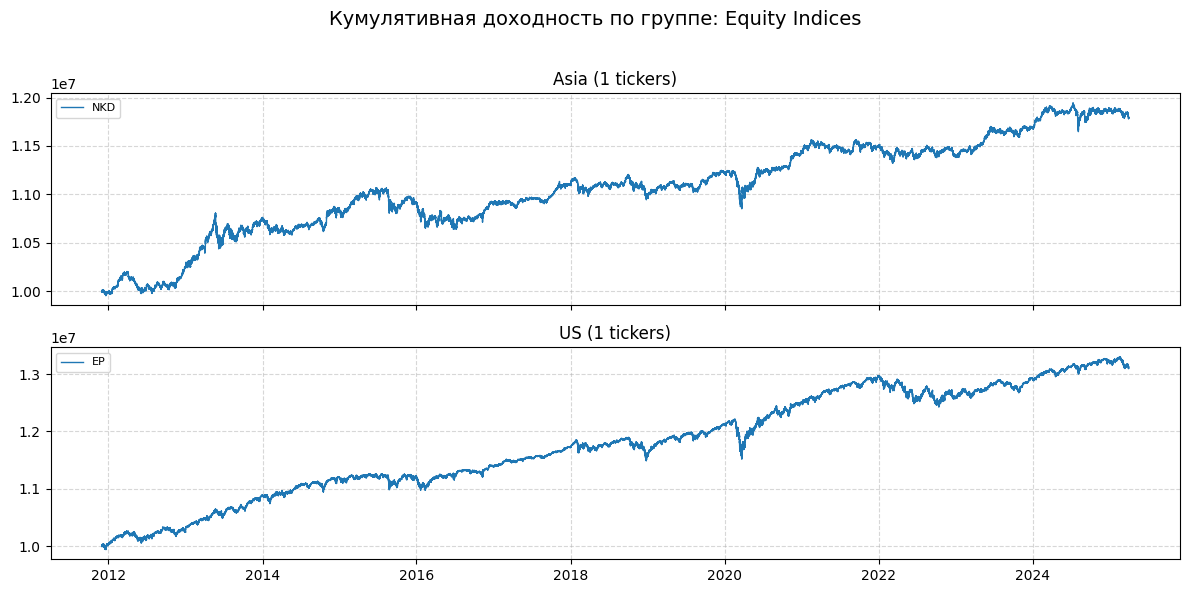

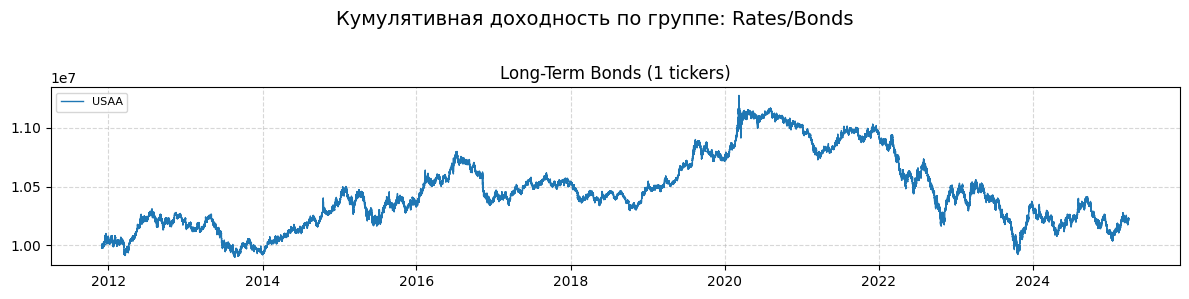

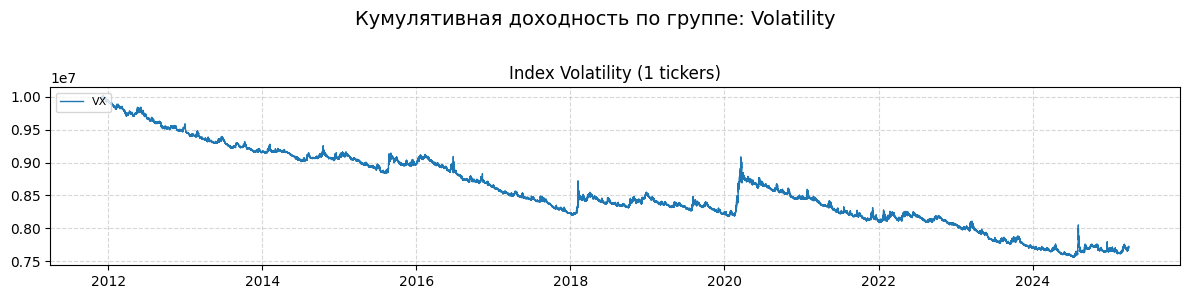

In [168]:
category_df = pd.DataFrame.from_dict(CATEGORIES, orient='index', columns=['Group', 'Subgroup'])
existing_tickers = [t for t in category_df.index if t in data.columns]
category_df = category_df.loc[existing_tickers]

for group_name, subgroup_df in category_df.groupby('Group'):
    subgroups = subgroup_df['Subgroup'].unique()
    n_subgroups = len(subgroups)
    
    fig, axes = plt.subplots(n_subgroups, 1, figsize=(12, 3 * n_subgroups), sharex=True)
    if n_subgroups == 1:
        axes = [axes]
    
    fig.suptitle(f'Кумулятивная доходность по группе: {group_name}', fontsize=14)
    
    for ax, subgrp in zip(axes, subgroups):
        subgrp_tickers = subgroup_df[subgroup_df['Subgroup'] == subgrp].index
        for ticker in subgrp_tickers:
            ax.plot(data.index, data[ticker], label=ticker, linewidth=1)
        
        ax.set_title(f'{subgrp} ({len(subgrp_tickers)} tickers)')
        ax.legend(fontsize=8, loc='upper left', ncol=3)
        ax.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

Проверк ана наличие дубликатов

In [169]:
data.duplicated().sum()

np.int64(3)

Отсутствуют.

Быстрая проверка базовой статистики на подозрительное поведение

In [170]:
styled = (
    data.describe(percentiles=[.01, .05, .95, .99])
    .T.round(0).astype(int)
    .style.background_gradient(cmap='viridis')
)
styled

,count,mean,std,min,1%,5%,50%,95%,99%,max
BOA,4760324,9545334,669323,8615150,8709185,8824442,9479839,10372797,10509868,10632076
BPA,4760384,9570542,417449,8538783,8880957,9089653,9472565,10177984,10301112,10351474
BTC,2595200,10264110,373843,9494455,9541712,9657410,10382080,10765070,10765070,10780839
CAA,4760384,9271829,557381,8502182,8593576,8782440,9126961,10111690,10179945,10269185
CCA,4759784,10399745,726584,9770632,9840836,9883669,10168990,12457578,13316648,13600480
CLA,4760384,9548106,595579,7898266,8708689,8940849,9559270,10017124,10112932,10221543
CNA,4760324,9779997,641094,8811806,8855146,9065906,9782970,10589439,10793632,10985032
CPA,4760384,9868526,401759,9023906,9109944,9197238,9822950,10494286,10600969,10736684
CTA,4760204,9951142,601815,9082364,9269461,9387945,9827017,10770355,11145352,11361998
DAA,4760384,9596181,285486,8820813,9077929,9199770,9564744,10130210,10189384,10242034


Визуально, значительных выбросов и аномалий нет

### Стратегия

Выберем один актив, построим для него лог-доходности

In [171]:
selected_asset = 'CPA'  
asset_data = data[[selected_asset]]
asset_data = asset_data.interpolate(method='linear')
daily_prices = asset_data.resample('1D').last()
data = pd.DataFrame({
    'log_ret': np.log(daily_prices[selected_asset] / daily_prices[selected_asset].shift(1))
}).dropna()
data.head()

,log_ret
timestamp,
2011-12-02,0.002171
2011-12-06,0.001366
2011-12-07,-0.001071
2011-12-08,-0.003242
2011-12-09,0.003960


Графики

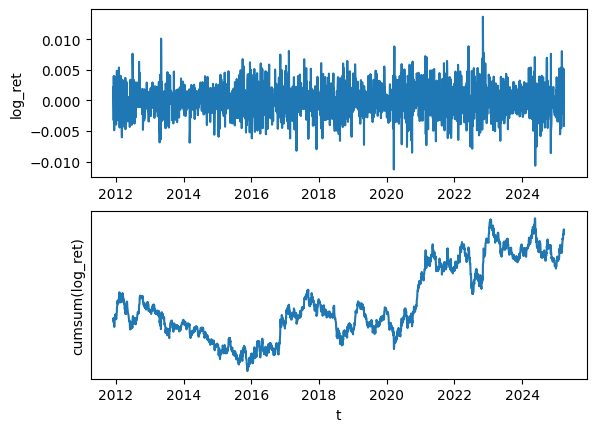

In [172]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(data)
ax1.set_ylabel('log_ret')

ax2.plot(data.cumsum())
ax2.set_yticks([])
ax2.set_ylabel('cumsum(log_ret)')
_ = ax2.set_xlabel('t')

Определим функцию, которая возвращает временной ряд наклонов, рассчитаных с помощью линейной регрессии скользящим методом

In [173]:
from scipy.stats import linregress

def get_rolling_slope(series: pd.Series, window: int) -> pd.Series:
    slopes = []
    index = []
    
    for i in range(window, len(series)):
        y = series.iloc[i-window:i].values
        x = np.arange(window)
        slope, *_ = linregress(x, y)
        slopes.append(slope)
        index.append(series.index[i])
    
    return pd.Series(slopes, index=index)

Создадим датасет с значениями наклонов

In [174]:
trend_window = 175
scale_factor = 1e3
slopes = get_rolling_slope(data['log_ret'], trend_window) * scale_factor

Посмотрим на график

<Figure size 1200x400 with 0 Axes>

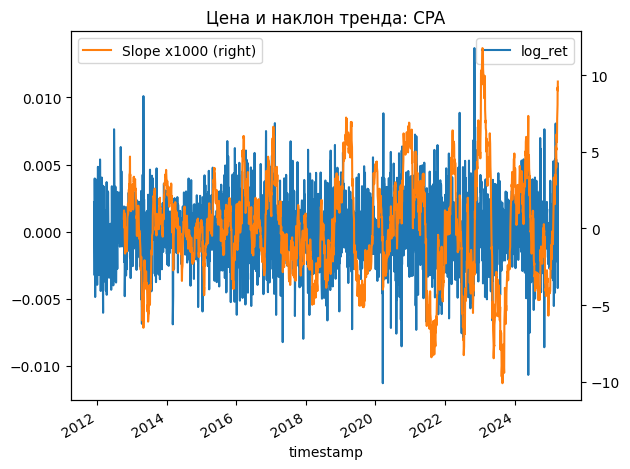

In [175]:
plt.figure(figsize=(12, 4))
data.plot(label='Price')
(slopes * 1000).plot(label='Slope x1000', secondary_y=True)
plt.title(f"Цена и наклон тренда: {selected_asset}")
plt.legend()
plt.tight_layout()
plt.show()


### Стратегия mean-reversion с учетом тренда:

Определим начальные временные параметры

In [176]:
trend_window = 20 
scale = 50 

Загрузим данные

In [177]:
log_ret = data['log_ret']
log_price = log_ret.cumsum()

Сигнал mean-reversion на лог-цене

In [178]:
rolling_mean = log_price.rolling(trend_window).mean()
rolling_std = log_price.rolling(trend_window).std()
z_score = -(log_price - rolling_mean) / rolling_std 

Расчёт локального тренда 

In [179]:
trend_window = 175
scale_factor = 1e3
slopes = get_rolling_slope(data['log_ret'], trend_window) * scale_factor
slope_aligned = slopes.reindex(z_score.index).fillna(0)

Вес на основе тренда

In [180]:
def slope_weight(slope, scale=15):
    return np.exp(scale * slope)

weight = slope_weight(slope_aligned, scale)

Позиция и доходность стратегии

In [181]:
position = z_score * weight
strategy_ret = position.shift(1) * log_ret  
cumulative = strategy_ret.cumsum()

Визуализация

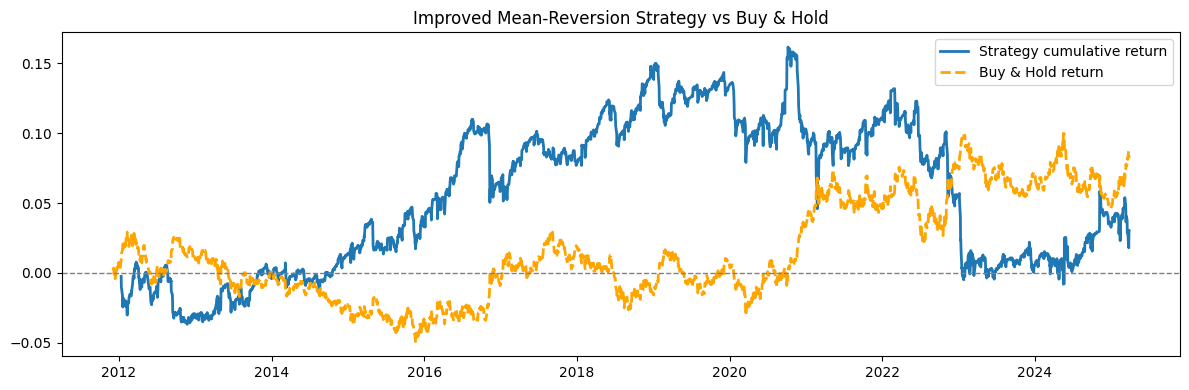

In [182]:
buy_hold = (1 + data).cumprod() - 1

plt.figure(figsize=(12, 4))

plt.plot(cumulative, label='Strategy cumulative return', linewidth=2)
plt.plot(buy_hold, label='Buy & Hold return', linestyle='--', color='orange', linewidth=2)

plt.title('Improved Mean-Reversion Strategy vs Buy & Hold')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.legend()
plt.tight_layout()
plt.show()

Рассчет доходности

In [183]:
final_return = cumulative.iloc[-1]
final_return_pct = final_return * 100
final_return_x = 1 + final_return

print(f"Доходность стратегии: {final_return_pct:.2f}%")
print(f"Доходность стратегии в иксах: {final_return_x:.2f}x")


Доходность стратегии: 3.03%
Доходность стратегии в иксах: 1.03x


### Подбор гиперпараметров

In [184]:
def run_strategy(trend_window, scale):
    
    rolling_mean = log_price.rolling(trend_window).mean()
    rolling_std = log_price.rolling(trend_window).std()
    z_score = -(log_price - rolling_mean) / rolling_std

    slope = get_rolling_slope(log_price, trend_window)
    slope_aligned = slope.reindex(z_score.index).fillna(0)
    weight = slope_weight(slope_aligned, scale)

    position = z_score * weight
    strategy_ret = position.shift(1) * log_ret

    cumulative = strategy_ret.cumsum()
    final_return = cumulative.iloc[-1]
    sharpe = strategy_ret.mean() / strategy_ret.std() * np.sqrt(252) if strategy_ret.std() > 0 else 0
    
    return final_return, sharpe

trend_windows = np.linspace(100, 200, num=5).astype(int)
scales = np.linspace(1, 15, num=10).round(4)
results = []

for i in trend_windows:
    for s in scales:
        final_ret, sharpe = run_strategy(i, s)
        results.append({
            'trend_window': i,
            'scale': s,
            'final_return': final_ret,
            'sharpe': sharpe
        })

results_df = pd.DataFrame(results)
best_params = results_df.loc[results_df['sharpe'].idxmax()]

print("Лучшие параметры по Sharpe ratio:")
print(best_params)


Лучшие параметры по Sharpe ratio:
trend_window    175.000000
scale             1.000000
final_return      0.259264
sharpe            0.475644
Name: 30, dtype: float64


### Используем лучшие параметры:

In [185]:
trend_window = 175 
scale = 15

Сигнал mean-reversion на лог-цене

In [186]:
rolling_mean = log_price.rolling(trend_window).mean()
rolling_std = log_price.rolling(trend_window).std()
z_score = -(log_price - rolling_mean) / rolling_std

Расчёт локального тренда

In [187]:
trend_window = 175
scale_factor = 1e3
slopes = get_rolling_slope(data['log_ret'], trend_window) * scale_factor
slope_aligned = slopes.reindex(z_score.index).fillna(0)

Позиция и доходность стратегии

In [188]:
weight = slope_weight(slope_aligned, scale)

position = z_score * weight
strategy_ret = position.shift(1) * log_ret 
cumulative = strategy_ret.cumsum()

Визуализация

C:\Users\masha\AppData\Local\Temp\ipykernel_25812\1152540894.py:3: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(buy_hold, label='Buy & Hold return', linestyle='--', color='orange', linewidth=2)


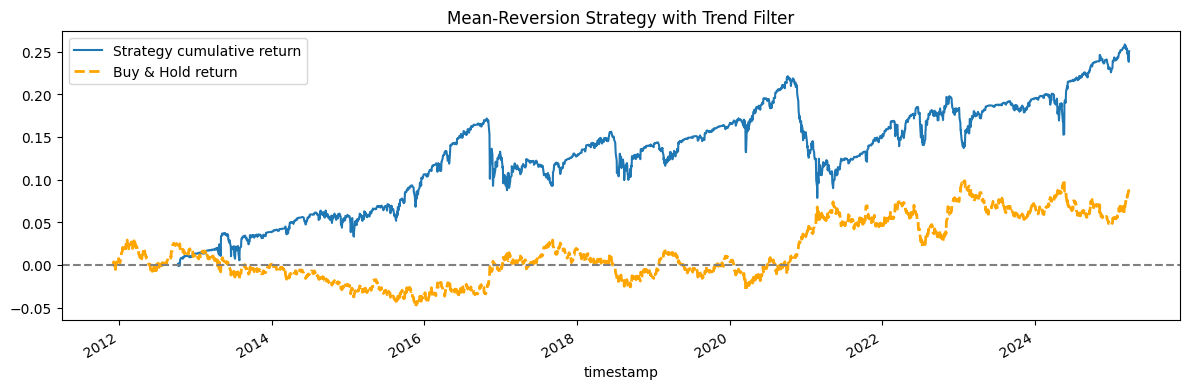

In [189]:
plt.figure(figsize=(12, 4))
cumulative.plot(label='Strategy cumulative return')
plt.plot(buy_hold, label='Buy & Hold return', linestyle='--', color='orange', linewidth=2)
plt.title('Mean-Reversion Strategy with Trend Filter')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()


Рассчет доходности

In [190]:
final_return = cumulative.iloc[-1]
final_return_pct = final_return * 100
final_return_x = 1 + final_return

print(f"Доходность стратегии: {final_return_pct:.2f}%")
print(f"Доходность стратегии в иксах: {final_return_x:.2f}x")

Доходность стратегии: 25.03%
Доходность стратегии в иксах: 1.25x


### Оптимизируем стратегию:

- Добавим контроль волатиности
- Ограничим максимальное абсолютное значение позиции

Параметры

In [191]:
trend_window = 175
scale = 1
vol_floor = 1e-4
position_clip = 19  # параметр подобран эмпирически- максимизирует доходность

Волатильность

In [192]:
rolling_vol = log_ret.rolling(trend_window).std()
rolling_vol_clipped = rolling_vol.clip(lower=vol_floor)

raw_position = z_score * weight
position = raw_position / rolling_vol_clipped

Ограничение позиции

In [193]:
position = position.clip(lower=-position_clip, upper=position_clip)
position = position.fillna(0)

Доходность

In [194]:
strategy_ret = position.shift(1) * log_ret
strategy_ret = strategy_ret.fillna(0)
cumulative = (strategy_ret + 1).cumprod() - 1

Визуализация

C:\Users\masha\AppData\Local\Temp\ipykernel_25812\2028062569.py:3: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(buy_hold, label='Buy & Hold return', linestyle='--', color='orange', linewidth=2)


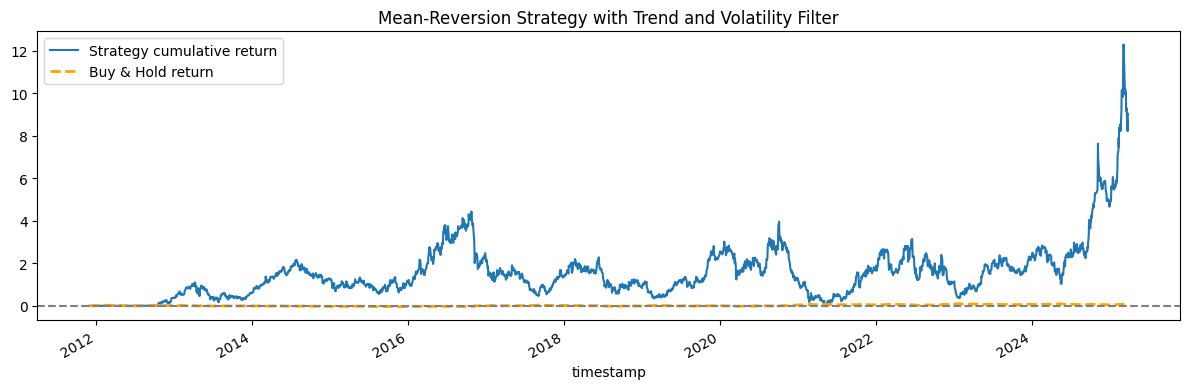

In [195]:
plt.figure(figsize=(12, 4))
cumulative.plot(label='Strategy cumulative return')
plt.plot(buy_hold, label='Buy & Hold return', linestyle='--', color='orange', linewidth=2)
plt.title('Mean-Reversion Strategy with Trend and Volatility Filter')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()


In [196]:
final_return = cumulative.iloc[-1]
final_return_pct = final_return * 100
final_return_x = 1 + final_return

print(f"Доходность стратегии: {final_return_pct:.2f}%")
print(f"Доходность стратегии в иксах: {final_return_x:.2f}x")

Доходность стратегии: 903.95%
Доходность стратегии в иксах: 10.04x


### Метрики стратегии

Sharpe Ratio (предполагаем 252 торговых дня в году)

In [197]:
avg_daily_ret = strategy_ret.mean()
std_daily_ret = strategy_ret.std()
sharpe_ratio = (avg_daily_ret / std_daily_ret) * np.sqrt(252)

Максимальная просадка

In [198]:
cumulative_curve = (strategy_ret + 1).cumprod()
rolling_max = cumulative_curve.cummax()
drawdown = (cumulative_curve - rolling_max) / rolling_max
max_drawdown = drawdown.min()

Средняя доходность и средняя просадка

In [199]:
mean_return = strategy_ret.mean() * 252
mean_drawdown = drawdown[drawdown < 0].mean()

Коэффициент восстановления

In [200]:
recovery_factor = final_return / abs(max_drawdown)

In [201]:
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Макс. просадка: {max_drawdown:.2%}")
print(f"Средняя годовая доходность: {mean_return:.2%}")
print(f"Средняя просадка: {mean_drawdown:.2%}")
print(f"Коэффициент восстановления: {recovery_factor:.2f}")


Sharpe Ratio: 0.65
Макс. просадка: -82.06%
Средняя годовая доходность: 43.37%
Средняя просадка: -42.63%
Коэффициент восстановления: 11.02


Довольно низкое значение Sharpe Ratio указывает, что стратегия генерирует положительную доходность, но уровень риска все еще довольно заметен.

Итоговая запись стратегии в виде функции

In [202]:
def mean_reversion_strategy(data, trend_window=175, scale=15, vol_floor=1e-4, position_clip=19):
    import numpy as np
    from scipy.stats import linregress
    import pandas as pd

    log_ret = data
    log_price = log_ret.cumsum()

    rolling_mean = log_price.rolling(trend_window).mean()
    rolling_std = log_price.rolling(trend_window).std()
    z_score = -(log_price - rolling_mean) / rolling_std

    rolling_vol = log_ret.rolling(trend_window).std()
    rolling_vol_clipped = rolling_vol.clip(lower=vol_floor)

    def get_rolling_slope(series: pd.Series, window: int) -> pd.Series:
        slopes = []
        index = []
        for i in range(window, len(series)):
            y = series.iloc[i-window:i].values
            x = np.arange(window)
            slope, *_ = linregress(x, y)
            slopes.append(slope)
            index.append(series.index[i])
        return pd.Series(slopes, index=index)

    slope = get_rolling_slope(log_price, trend_window)
    slope_aligned = slope.reindex(z_score.index).fillna(0)

    scale_factor = 1e3
    slope_scaled = slope_aligned * scale_factor

    def slope_weight(slope, scale=scale):
        return np.exp(scale * slope)

    weight = slope_weight(slope_scaled, scale)

    raw_position = z_score * weight
    position = raw_position / rolling_vol_clipped
    position = position.clip(lower=-position_clip, upper=position_clip).fillna(0)

    strategy_ret = position.shift(1) * log_ret
    return strategy_ret.fillna(0)


### Составление портфеля на основе стратегии

Еще раз считаем данные

In [203]:
data = pd.read_csv('futures-pnls.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

Преобразуем в лог-доходности

In [204]:
data = data.select_dtypes(include=[np.number])
data = data.interpolate(method='linear')
daily_prices = data.resample('1D').last()
log_ret = np.log(daily_prices / daily_prices.shift(1))
log_ret = log_ret.dropna()

Определим функцию для применения стратегии к нескольким активам

In [205]:
def run_mean_reversion_for_group(log_ret: pd.DataFrame, asset_list: list, trend_window=175, scale=15,
                                  vol_floor=1e-4, position_clip=19):
    def get_rolling_slope(series: pd.Series, window: int) -> pd.Series:
        slopes = []
        index = []
        for i in range(window, len(series)):
            y = series.iloc[i - window:i].values
            x = np.arange(window)
            slope, *_ = linregress(x, y)
            slopes.append(slope)
            index.append(series.index[i])
        return pd.Series(slopes, index=index)

    def slope_weight(slope, scale=15): 
        return np.exp(scale * slope)

    results = {}

    for asset in asset_list:
        log_ret_series = log_ret[asset]
        log_price = log_ret_series.cumsum()

        rolling_mean = log_price.rolling(trend_window).mean()
        rolling_std = log_price.rolling(trend_window).std()
        z_score = -(log_price - rolling_mean) / rolling_std

        rolling_vol = log_ret_series.rolling(trend_window).std()
        rolling_vol_clipped = rolling_vol.clip(lower=vol_floor)

        slope = get_rolling_slope(log_price, trend_window)
        slope_scaled = slope * 1e3  # scale factor as in original
        slope_aligned = slope_scaled.reindex(z_score.index).fillna(0)

        weight = slope_weight(slope_aligned, scale=scale)

        raw_position = z_score * weight
        position = raw_position / rolling_vol_clipped
        position = position.clip(lower=-position_clip, upper=position_clip).fillna(0)

        strategy_ret = position.shift(1) * log_ret_series
        strategy_ret = strategy_ret.fillna(0)

        results[asset] = strategy_ret

    return pd.DataFrame(results)


Посчитаем доходности для каждого актива

In [206]:
def get_cumulative_returns(log_ret, assets, trend_window, scale):
    returns = run_mean_reversion_for_group(log_ret, assets, trend_window, scale)
    cumulative = np.exp(returns.cumsum()) - 1
    cumulative_return_pct = cumulative.iloc[-1] * 100 
    return cumulative_return_pct.round(2)

trend_window = 150
scale = 10
all_assets = log_ret.columns

all_returns = get_cumulative_returns(log_ret, all_assets, trend_window, scale)
all_returns.name = 'Cumulative Return %'

all_returns.sort_values(ascending=False)


PLA     2237.99
CPA     1818.24
DAA     1032.74
NKD      686.21
EP       386.82
CAA      343.55
SFA      237.82
WHA      224.44
VX       165.83
BPA      137.48
CNA      125.58
LHA       23.28
GLA        8.18
CLA        1.39
KCA      -24.32
USAA     -25.61
BTC      -35.98
PAA      -48.87
CTA      -54.52
MXA      -58.15
EUA      -59.79
GCA      -63.43
SBA      -77.64
BOA      -86.44
NGA      -88.48
CCA      -92.98
Name: Cumulative Return %, dtype: float64

Cредняя доходность по всем активам

In [207]:
all_returns.mean()

np.float64(258.20538461538456)

Составим портфель из 6 активов с наибольшей доходностью

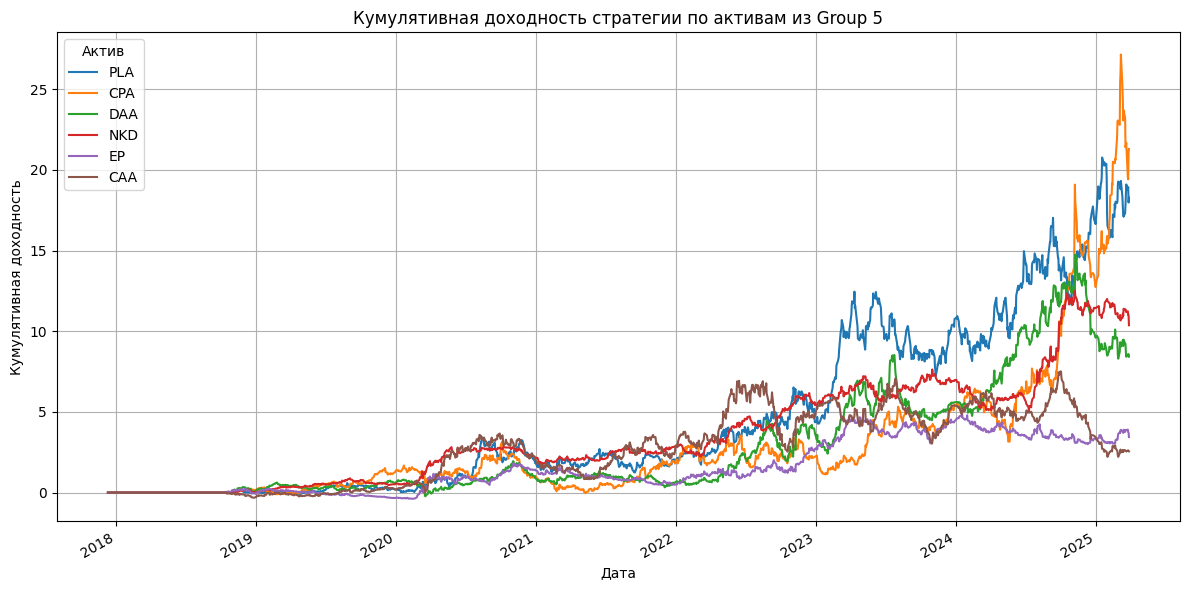

PLA    1827.09
CPA    2129.15
DAA     842.51
NKD    1037.24
EP      344.28
CAA     255.64
Name: 2025-03-28 00:00:00, dtype: float64
Кумулятивная доходность портфеля из группы 5: 848.36%


In [208]:
group5 = ['PLA', 'CPA', 'DAA', 'NKD', 'EP', 'CAA']
group5_returns = run_mean_reversion_for_group(log_ret, group5, trend_window=175, scale=15)

plt.figure(figsize=(12, 6))
(np.exp(group5_returns.cumsum()) - 1).plot(ax=plt.gca())
plt.title("Кумулятивная доходность стратегии по активам из Group 5")
plt.xlabel("Дата")
plt.ylabel("Кумулятивная доходность")
plt.legend(title="Актив")
plt.grid(True)
plt.tight_layout()
plt.show()

cumulative = np.exp(group5_returns.cumsum()) - 1
cumulative_return_pct = cumulative.iloc[-1] * 100
cumulative_return_pct = cumulative_return_pct.round(2)
print(cumulative_return_pct)

group5_portfolio_returns = group5_returns.mean(axis=1)
group5_portfolio_cum_return = np.exp(group5_portfolio_returns.cumsum()) - 1
group5_portfolio_cum_return_pct = round(group5_portfolio_cum_return.iloc[-1] * 100, 2)
print(f"Кумулятивная доходность портфеля из группы 5: {group5_portfolio_cum_return_pct}%")


### Выводы
##### **Активы с наибольшей доходностью:**
- Платина (PLA)
- Медные фьючерсы (CPA)
- Австралийский доллар (DAA)
- Никкей 225 (NKD)
- E Mini S&P (EP)
- Канадский доллар (CAA)

Такие инструменты, как драгоценные металлы (платина), промышленные металлы (медь), а также индексы акций, часто подвержены фундаментальным факторам спроса и предложения, циклам промышленности, что создает устойчивые циклы. В этих условиях данная стратегия наиболее эффективна.

##### **Активы с наименьшей доходностью:**
- Cocoa (CCA)
- Natural Gas (NGA)
- Cotton (CTA)
- Sugar (SBA)
- Mexican Peso (MXA)

Активы с сильными отрицательными результатами- это, в основном, soft commodities (мягкие товары), некоторые валюты с высокой волатильностью, а также нефть и газ. Для них характерна либо нерегулярность циклов возврата к средним, либо длительные трендовые движения без выраженных откатов, что снижает эффективность mean-reversion.

Средняя доходность за весь период по всем активам равна 258%, что совсем не много, что еще раз подтверждает факт, что стратегия не универсальна. Из этого следует, что для этой стратегии нужно грамотно отбирать активы. 

Также следует подбирать гиперпараметры отдельно для каждого актива. 

В итоге можно сделать вывод, что гипотеза, сформулированная в начале исследования
"Сильный тренд указывает на фазу перекупленности или перепроданности, и это повышает вероятность отката"
не отвергается.